<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/VAE_Diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#繪圖中文設定

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

print(" 環境設置完成！")

--2025-09-26 04:40:37--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.170.102, 64.233.170.139, 64.233.170.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-09-26 04:40:38--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  42.1MB/s    in 0.5s    

2025-09-26 04:40:

#四種模型

##VAE

### 模型設定


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

class VAE(nn.Module):
    """
    Variational Autoencoder for MNIST
    按照要求：将输入图像展平，压缩到潜在空间(z)，输出均值μ与对数方差log σ²
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 28*28 = 784
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim  # 潜在空间维度

        # Encoder: 将输入图像编码到潜在空间
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # 潜在空间的均值和对数方差
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # 均值 μ
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 对数方差 log σ²

        # Decoder: 从潜在空间z还原图像 (28×28)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 输出到[0,1]范围
        )

    def encode(self, x):
        """编码：输入图像 -> 潜在空间参数 (μ, log σ²)"""
        # 展平图像
        x = x.view(x.size(0), -1)  # (batch_size, 784)

        # 通过编码器
        h = self.encoder(x)

        # 输出均值和对数方差
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重参数化技巧：从 N(μ, σ²) 采样"""
        std = torch.exp(0.5 * logvar)  # σ = exp(0.5 * log σ²)
        eps = torch.randn_like(std)    # 从标准正态分布采样
        z = mu + eps * std             # z = μ + ε * σ
        return z

    def decode(self, z):
        """解码：潜在变量z -> 重构图像"""
        x_recon = self.decoder(z)
        return x_recon.view(x_recon.size(0), 1, 28, 28)  # 重塑为图像格式

    def forward(self, x):
        """VAE前向传播"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def sample(self, num_samples=10, device='cpu'):
        """从潜在空间采样生成新图像"""
        with torch.no_grad():
            # 从标准正态分布采样
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
        return samples


def vae_loss_function(recon_x, x, mu, logvar):
    """
    VAE损失函数 = 重建损失(BCE) + KL散度损失
    """
    # 重建损失 (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(
        recon_x.view(-1, 784),
        x.view(-1, 784),
        reduction='sum'
    )

    # KL散度损失: D_KL(q(z|x) || p(z))
    # 其中 q(z|x) = N(μ, σ²), p(z) = N(0, I)
    # KLD = -0.5 * sum(1 + log σ² - μ² - σ²)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

### 資料預處理收集

In [ ]:

def get_mnist_dataloaders(batch_size=128):
    """
    载入MNIST数据集 - 简化版：训练集 + 测试集
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # 训练集
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # 测试集
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"数据集信息:")
    print(f"  训练集: {len(train_dataset)} 张图片")
    print(f"  测试集: {len(test_dataset)} 张图片")

    return train_dataloader, test_dataloader


### 訓練和可視化

In [ ]:
def train_vae_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    訓練VAE模型 - 包含訓練集和測試集評估
    按照要求：
    - Batch size: 128
    - Optimizer: Adam, lr=1e-3
    - Loss: 重建BCE + KLD
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # 訓練監控指標
    training_metrics = {
        'train_losses': [],      # 訓練損失
        'test_losses': [],       # 測試損失
        'train_bce_losses': [],  # 訓練重建損失
        'train_kld_losses': [],  # 訓練KL散度損失
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("開始訓練MNIST VAE模型...")
    print(f"訓練集大小: {len(train_dataloader.dataset)}")
    print(f"測試集大小: {len(test_dataloader.dataset)}")
    print(f"批次大小: {train_dataloader.batch_size}")
    print(f"訓練批次數: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ 訓練階段 ============
        model.train()
        total_train_loss = 0
        total_train_bce = 0
        total_train_kld = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, _) in enumerate(train_dataloader):
            data = data.to(device)

            # 前向傳播
            recon_batch, mu, logvar = model(data)

            # 計算損失
            loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar)

            # 反向傳播
            optimizer.zero_grad()
            loss.backward()

            # 計算梯度範數
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            # 記錄損失
            total_train_loss += loss.item()
            total_train_bce += bce.item()
            total_train_kld += kld.item()
            training_metrics['batch_losses'].append(loss.item())

            # 每200個批次且每10個epoch顯示進度
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Total Loss: {loss.item()/len(data):.4f}, BCE: {bce.item()/len(data):.4f}, '
                          f'KLD: {kld.item()/len(data):.4f}')

        # ============ 測試階段 ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
                total_test_loss += loss.item()

        # 記錄epoch指標
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / len(train_dataloader.dataset)
        avg_test_loss = total_test_loss / len(test_dataloader.dataset)
        avg_train_bce = total_train_bce / len(train_dataloader.dataset)
        avg_train_kld = total_train_kld / len(train_dataloader.dataset)
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['train_bce_losses'].append(avg_train_bce)
        training_metrics['train_kld_losses'].append(avg_train_kld)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - 訓練損失: {avg_train_loss:.4f}, '
              f'測試損失: {avg_test_loss:.4f}, 重建損失: {avg_train_bce:.4f}, '
              f'KL損失: {avg_train_kld:.4f}, 梯度範數: {avg_grad_norm:.4f}, '
              f'用時: {epoch_time:.1f}秒')
        print("-" * 60)

    # 總訓練時間
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("VAE訓練完成！")
    print(f"總訓練時間: {total_training_time/60:.2f} 分鐘")
    print(f"平均每epoch時間: {np.mean(training_metrics['epoch_times']):.1f} 秒")
    print(f"最終訓練損失: {training_metrics['train_losses'][-1]:.4f}")
    print(f"最終測試損失: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def generate_vae_images(model, num_images=10, device='cuda'):
    """
    隨機生成VAE圖像 - 增加推理時間記錄
    """
    model.eval()

    # 設定隨機種子 (seed=42)
    torch.manual_seed(42)

    # 推理計時開始
    inference_start_time = time.time()

    print(f"正在生成 {num_images} 張MNIST圖像...")
    generated_images = model.sample(num_images, device=device)

    # 推理計時結束
    inference_time = time.time() - inference_start_time

    print(f"VAE生成完成！推理時間: {inference_time:.4f} 秒")
    print(f"平均每張圖片: {inference_time/num_images:.4f} 秒")

    return generated_images, inference_time


def visualize_vae_images(images, title="Generated VAE MNIST Images", inference_time=None):
    """
    視覺化VAE生成的MNIST圖片 - 增加推理時間顯示
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # 標題中加入推理時間資訊
    if inference_time is not None:
        full_title = f"{title}\n推理時間: {inference_time:.4f}秒, 平均每張: {inference_time/len(images):.4f}秒"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_vae_training_metrics(training_metrics):
    """
    繪製VAE訓練指標 - 包含訓練損失和測試損失對比
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('VAE 訓練指標分析', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. 訓練損失 vs 測試損失
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='訓練集總損失', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='測試集總損失', marker='s', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['train_bce_losses'], 'g--',
                    linewidth=1, label='訓練重建損失(BCE)', alpha=0.7)
    axes[0, 0].plot(epochs, training_metrics['train_kld_losses'], 'm--',
                    linewidth=1, label='訓練KL散度損失', alpha=0.7)
    axes[0, 0].set_title('VAE損失組件分析')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(loc='upper right', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 泛化分析 (訓練損失 - 測試損失)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='訓練 > 測試 (過擬合風險)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='測試 ≤ 訓練 (良好泛化)')
    axes[0, 1].set_title('泛化能力分析 (訓練損失 - 測試損失)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('損失差值')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # 添加解釋文字
    axes[0, 1].text(0.02, 0.95, '> 0: 訓練損失高於測試損失\n< 0: 測試損失高於訓練損失',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. 每個epoch訓練時間
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('每個Epoch訓練時間')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('時間 (秒)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 梯度範數變化
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('梯度範數變化')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # 添加總結資訊
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"總訓練時間: {training_metrics['total_training_time']/60:.2f} 分鐘 | "
                      f"最終訓練損失: {final_train_loss:.4f} | 最終測試損失: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def test_vae_performance(model, test_dataloader, device='cuda'):
    """
    在測試集上評估VAE模型性能
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)

    print("在測試集上評估VAE模型...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # 前向傳播
            recon_batch, mu, logvar = model(data)

            # 計算損失
            loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader.dataset)
    print(f"測試集平均損失: {avg_test_loss:.4f}")
    return avg_test_loss

### 主程式和結果

使用设备: cuda
載入MNIST資料...
数据集信息:
  训练集: 60000 张图片
  测试集: 10000 张图片
創建VAE模型...
VAE參數量: 973,624
訓練VAE...
開始訓練MNIST VAE模型...
訓練集大小: 60000
測試集大小: 10000
批次大小: 128
訓練批次數: 469
Epoch [1/30], Batch [0/469], Total Loss: 545.4152, BCE: 545.3806, KLD: 0.0346
Epoch [1/30], Batch [200/469], Total Loss: 185.5229, BCE: 179.0086, KLD: 6.5144
Epoch [1/30], Batch [400/469], Total Loss: 144.0119, BCE: 132.3139, KLD: 11.6980
Epoch [1/30] - 訓練損失: 177.5400, 測試損失: 139.3901, 重建損失: 169.9817, KL損失: 7.5582, 梯度範數: 4502.3143, 用時: 9.8秒
------------------------------------------------------------
Epoch [2/30] - 訓練損失: 128.2907, 測試損失: 119.5961, 重建損失: 113.3678, KL損失: 14.9230, 梯度範數: 6653.0465, 用時: 9.9秒
------------------------------------------------------------
Epoch [3/30] - 訓練損失: 117.3064, 測試損失: 114.2438, 重建損失: 100.5432, KL損失: 16.7632, 梯度範數: 6959.5169, 用時: 11.2秒
------------------------------------------------------------
Epoch [4/30] - 訓練損失: 112.8759, 測試損失: 110.5005, 重建損失: 95.2664, KL損失: 17.6096, 梯度範數: 7309.2425, 用時: 1

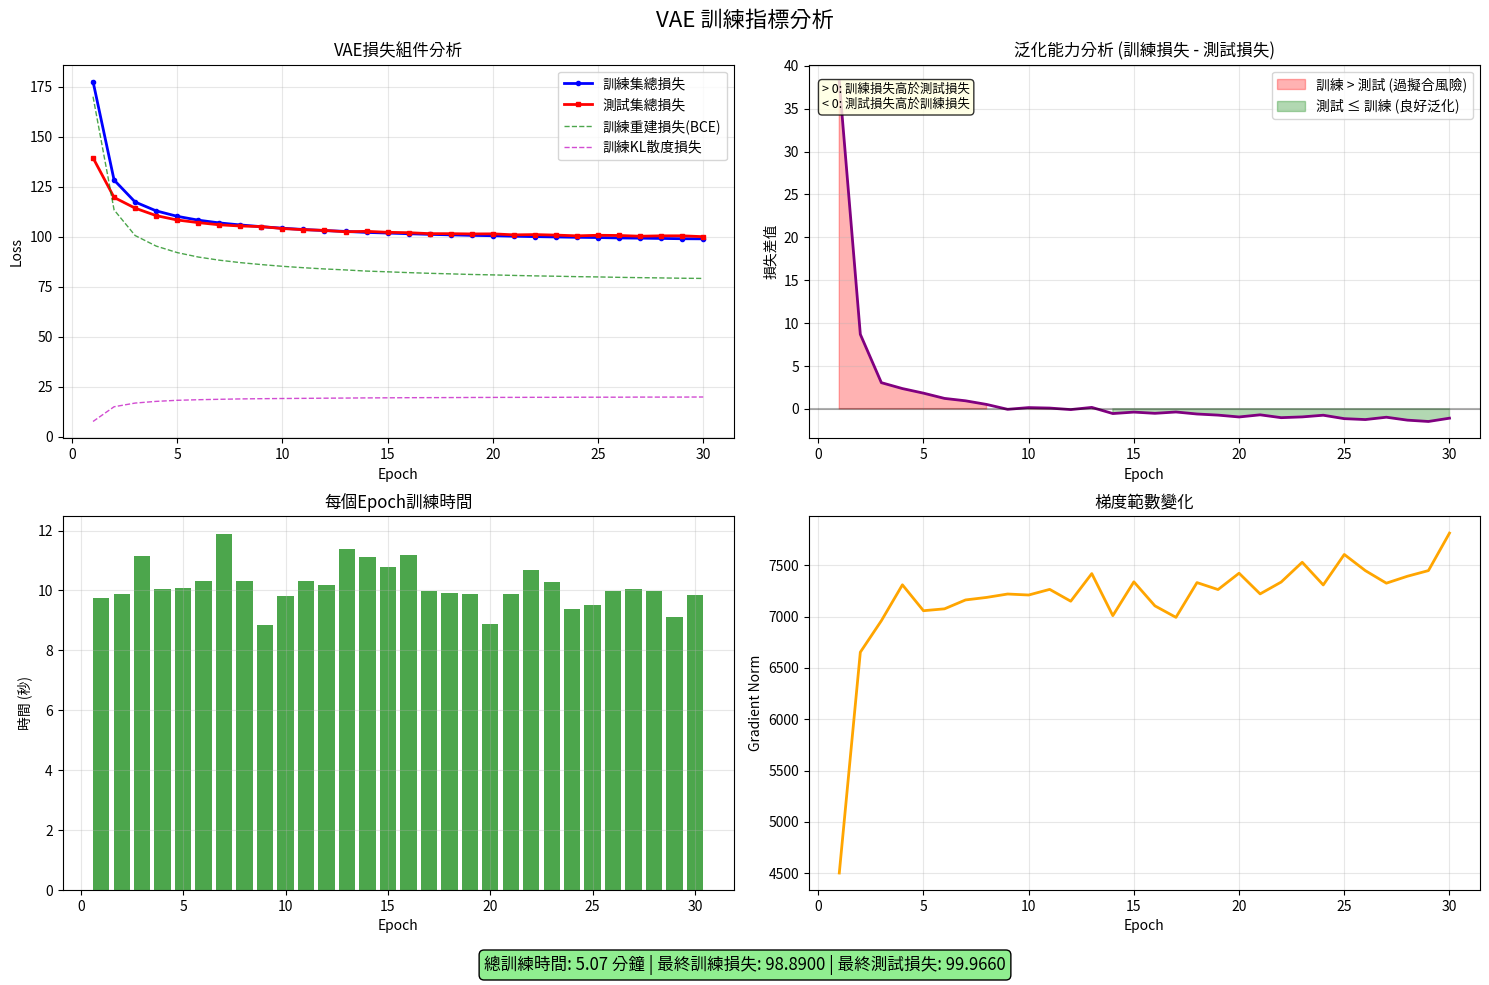

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

batch_size = 128  # 按照要求

# 1. 載入MNIST資料
print("載入MNIST資料...")
train_dataloader,test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

# 2. 創建VAE模型
print("創建VAE模型...")
vae_model = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
print(f"VAE參數量: {sum(p.numel() for p in vae_model.parameters()):,}")

# 3. 訓練VAE模型
print("訓練VAE...")
trained_vae_model, vae_training_metrics = train_vae_model(
    vae_model,
    train_dataloader,
    test_dataloader,
    epochs=30,  # 可调整
    lr=1e-3,    # 按照要求
    device=device
)

# 4. 訓練指標
plot_vae_training_metrics(vae_training_metrics)

生成VAE图像...
正在生成 10 張MNIST圖像...
VAE生成完成！推理時間: 0.0016 秒
平均每張圖片: 0.0002 秒


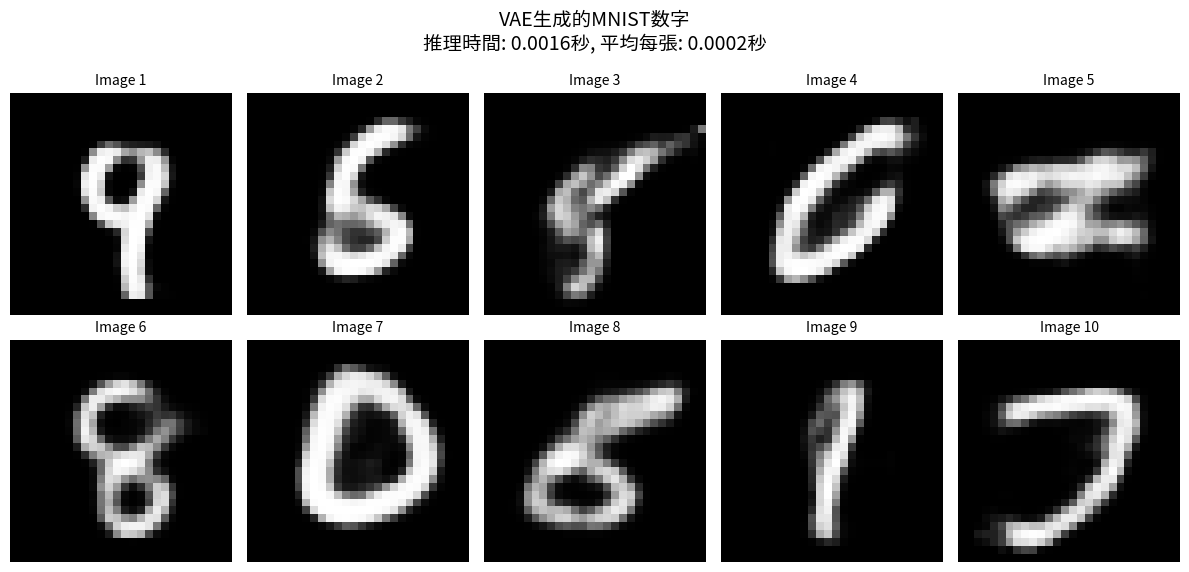

VAE模型已保存为 'mnist_vae_model.pth'


In [ ]:
# 5. 生成10张MNIST图像
print("生成VAE图像...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)

# 6. 可视化结果
visualize_vae_images(vae_generated_images, "VAE生成的MNIST数字", vae_inference_time)

# 7. 保存模型和训练指标
torch.save(trained_vae_model.state_dict(), 'mnist_vae_model.pth')
print("VAE模型已保存为 'mnist_vae_model.pth'")

##Diffusion model

###模型設定

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
import time

warnings.filterwarnings("ignore")
class DiffusionModel(nn.Module):
    def __init__(self, img_channels=1, img_size=28, timesteps=1000):
        super().__init__()
        self.img_channels = img_channels  # MNIST為1通道(灰階)
        self.img_size = img_size  # MNIST為28x28
        self.timesteps = timesteps

        # 建立噪聲調度
        self.beta_start = 0.0001
        self.beta_end = 0.02
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # 計算前向過程所需的常數
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # 計算後向過程所需的常數
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

        # U-Net 去噪網路 (適配MNIST)
        self.unet = UNet(img_channels, timesteps)

    def _cosine_beta_schedule(self):
        """餘弦調度器 - 更穩定的噪聲調度"""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + 0.008) / 1.008 * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)

    def forward_diffusion_sample(self, x_0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        前向過程：逐步將噪聲加到圖片上
        x_0: 原始MNIST圖片 (batch_size, 1, 28, 28)
        t: 時間步
        返回: (加噪後的圖片, 添加的噪聲)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self._get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # q(x_t | x_0) = N(sqrt(alpha_cumprod_t) * x_0, (1 - alpha_cumprod_t) * I)
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def _get_index_from_list(self, vals, t, x_shape):
        """從預計算的值中取出對應時間步的值"""
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward(self, x_0: torch.Tensor) -> torch.Tensor:
        """
        訓練時的前向傳播
        """
        device = x_0.device
        batch_size = x_0.shape[0]

        # 隨機選擇時間步
        t = torch.randint(0, self.timesteps, (batch_size,), device=device).long()

        # 前向擴散
        x_t, noise = self.forward_diffusion_sample(x_0, t)

        # 使用U-Net預測噪聲
        predicted_noise = self.unet(x_t, t)

        return predicted_noise, noise

    @torch.no_grad()
    def sample_timestep(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        逆向過程的單步採樣
        """
        betas_t = self._get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self._get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # 使用U-Net預測噪聲
        predicted_noise = self.unet(x, t)

        # 計算均值
        model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, num_samples: int, device: str = 'cpu') -> torch.Tensor:
        """
        逆向過程：從噪聲生成MNIST數字圖片
        """
        # 從純噪聲開始 (MNIST: 1通道, 28x28)
        x = torch.randn((num_samples, self.img_channels, self.img_size, self.img_size), device=device)

        # 逆向擴散
        for i in reversed(range(0, self.timesteps)):
            t = torch.full((num_samples,), i, device=device, dtype=torch.long)
            x = self.sample_timestep(x, t)

        return x


class UNet(nn.Module):
    """U-Net去噪網路 - 適配MNIST (28x28, 單通道)"""
    def __init__(self, img_channels=1, time_dim=1000):
        super().__init__()
        self.time_dim = time_dim

        # 時間嵌入
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # 下採樣路徑 (適配28x28輸入)
        self.downs = nn.ModuleList([
            Block(img_channels, 32, time_dim),  # 28x28 -> 14x14
            Block(32, 64, time_dim),            # 14x14 -> 7x7
            Block(64, 128, time_dim),           # 7x7 -> 3x3 (向下取整)
        ])

        # 瓶頸層
        self.bottleneck = Block(128, 256, time_dim)

        # 上採樣路徑
        self.ups = nn.ModuleList([
            Block(256 + 128, 128, time_dim),   # 3x3 -> 7x7
            Block(128 + 64, 64, time_dim),     # 7x7 -> 14x14
            Block(64 + 32, 32, time_dim),      # 14x14 -> 28x28
        ])

        # 輸出層
        self.output = nn.Conv2d(32, img_channels, 1)

    def forward(self, x, t):
        # 時間嵌入
        t = self.time_mlp(t)

        # 下採樣
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
            x = F.max_pool2d(x, 2)

        # 瓶頸
        x = self.bottleneck(x, t)

        # 上採樣
        for up in self.ups:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            residual_x = residuals.pop()
            # 確保維度匹配
            if x.shape != residual_x.shape:
                x = F.interpolate(x, size=residual_x.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)


class Block(nn.Module):
    """U-Net的基本塊"""
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(min(8, out_ch), out_ch)  # 適配較小的通道數
        self.norm2 = nn.GroupNorm(min(8, out_ch), out_ch)

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)

        # 加入時間嵌入
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2]  # 擴展維度以匹配特徵圖
        h = h + time_emb

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)

        return h


class SinusoidalPositionEmbeddings(nn.Module):
    """正弦位置嵌入用於時間步"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


###資料預處理和收集

In [ ]:
def get_mnist_dataloaders(batch_size=128):
    """
    载入MNIST数据集 - 简化版：训练集 + 测试集
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 归一化到[-1, 1]
    ])

    # 训练集
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # 测试集
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"数据集信息:")
    print(f"  训练集: {len(train_dataset)} 张图片")
    print(f"  测试集: {len(test_dataset)} 张图片")

    return train_dataloader, test_dataloader




###訓練和可視化

In [ ]:
def test_model_performance(model, test_dataloader, device='cuda'):
    """
    在測試集上評估模型性能
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)
    mse_loss = nn.MSELoss()

    print("在測試集上評估模型...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # 前向傳播
            predicted_noise, true_noise = model(data)

            # 計算損失
            loss = mse_loss(predicted_noise, true_noise)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / num_batches
    print(f"測試集平均損失: {avg_test_loss:.4f}")
    return avg_test_loss


def train_diffusion_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    訓練函數 - 包含訓練集和測試集評估
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    model.to(device)

    # 訓練監控指標
    training_metrics = {
        'train_losses': [],      # 訓練損失
        'test_losses': [],       # 測試損失
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("開始訓練MNIST Diffusion Model...")
    print(f"訓練集大小: {len(train_dataloader.dataset)}")
    print(f"測試集大小: {len(test_dataloader.dataset)}")
    print(f"批次大小: {train_dataloader.batch_size}")
    print(f"訓練批次數: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ 訓練階段 ============
        model.train()
        total_train_loss = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data = data.to(device)

            # 前向傳播
            predicted_noise, true_noise = model(data)

            # MSE去噪損失
            loss = mse_loss(predicted_noise, true_noise)

            # 反向傳播
            optimizer.zero_grad()
            loss.backward()

            # 計算梯度範數
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            total_train_loss += loss.item()
            training_metrics['batch_losses'].append(loss.item())

            # 每200個批次且每10個epoch顯示進度
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Train Loss: {loss.item():.4f}, Grad Norm: {total_grad_norm:.4f}')

        # ============ 測試階段 ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                predicted_noise, true_noise = model(data)
                loss = mse_loss(predicted_noise, true_noise)
                total_test_loss += loss.item()

        # 記錄epoch指標
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / num_batches
        avg_test_loss = total_test_loss / test_batches
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - 訓練損失: {avg_train_loss:.4f}, '
              f'測試損失: {avg_test_loss:.4f}, 梯度範數: {avg_grad_norm:.4f}, '
              f'用時: {epoch_time:.1f}秒')
        print("-" * 60)

    # 總訓練時間
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("訓練完成！")
    print(f"總訓練時間: {total_training_time/60:.2f} 分鐘")
    print(f"平均每epoch時間: {np.mean(training_metrics['epoch_times']):.1f} 秒")
    print(f"最終訓練損失: {training_metrics['train_losses'][-1]:.4f}")
    print(f"最終測試損失: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def plot_training_metrics(training_metrics):
    """
    繪製訓練指標 - 包含訓練損失和測試損失對比
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Diffusion Model 訓練指標分析', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. 訓練損失 vs 測試損失
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='訓練集損失', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='測試集損失', marker='s', markersize=3)
    axes[0, 0].set_title('訓練損失 vs 測試損失')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend(loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 泛化分析 (訓練損失 - 測試損失)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='訓練 > 測試 (過擬合風險)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='測試 ≤ 訓練 (良好泛化)')
    axes[0, 1].set_title('泛化能力分析 (訓練損失 - 測試損失)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('損失差值')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # 添加解釋文字
    axes[0, 1].text(0.02, 0.95, '> 0: 訓練損失高於測試損失\n< 0: 測試損失高於訓練損失',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. 每個epoch訓練時間
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('每個Epoch訓練時間')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('時間 (秒)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 梯度範數變化
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('梯度範數變化')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # 添加總結資訊
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"總訓練時間: {training_metrics['total_training_time']/60:.2f} 分鐘 | "
                      f"最終訓練損失: {final_train_loss:.4f} | 最終測試損失: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def generate_mnist_images(model, num_images=10, device='cuda'):
    """
    隨機生成MNIST數字影像 - 增加推理時間記錄
    """
    model.eval()

    # 推理計時開始
    inference_start_time = time.time()

    with torch.no_grad():
        torch.manual_seed(42)

        print(f"正在生成 {num_images} 張MNIST影像...")
        generated_images = model.sample(num_images, device=device)

        # 將值範圍從[-1, 1]轉換到[0, 1]
        generated_images = (generated_images + 1) / 2
        generated_images = torch.clamp(generated_images, 0, 1)

    # 推理計時結束
    inference_time = time.time() - inference_start_time

    print(f"生成完成！推理時間: {inference_time:.2f} 秒")
    print(f"平均每張圖片: {inference_time/num_images:.2f} 秒")

    return generated_images, inference_time


def visualize_mnist_images(images, title="Generated MNIST Images", inference_time=None):
    """
    視覺化生成的MNIST圖片 - 增加推理時間顯示
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # 標題中加入推理時間資訊
    if inference_time is not None:
        full_title = f"{title}\n推理時間: {inference_time:.2f}秒, 平均每張: {inference_time/len(images):.2f}秒"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

###主程式和結果

使用裝置: cuda
載入MNIST資料集...
数据集信息:
  训练集: 60000 张图片
  测试集: 10000 张图片
建立Diffusion Model...
模型參數量: 3,654,825
開始訓練...
開始訓練MNIST Diffusion Model...
訓練集大小: 60000
測試集大小: 10000
批次大小: 128
訓練批次數: 469
Epoch [1/30], Batch [0/469], Train Loss: 1.1403, Grad Norm: 7.9997
Epoch [1/30], Batch [200/469], Train Loss: 0.0749, Grad Norm: 0.7740
Epoch [1/30], Batch [400/469], Train Loss: 0.0591, Grad Norm: 0.2802
Epoch [1/30] - 訓練損失: 0.1038, 測試損失: 0.0632, 梯度範數: 0.6351, 用時: 36.5秒
------------------------------------------------------------
Epoch [2/30] - 訓練損失: 0.0591, 測試損失: 0.0560, 梯度範數: 0.4289, 用時: 38.1秒
------------------------------------------------------------
Epoch [3/30] - 訓練損失: 0.0530, 測試損失: 0.0507, 梯度範數: 0.3316, 用時: 36.5秒
------------------------------------------------------------
Epoch [4/30] - 訓練損失: 0.0498, 測試損失: 0.0487, 梯度範數: 0.2954, 用時: 36.4秒
------------------------------------------------------------
Epoch [5/30] - 訓練損失: 0.0479, 測試損失: 0.0467, 梯度範數: 0.2826, 用時: 37.2秒
----------------------------

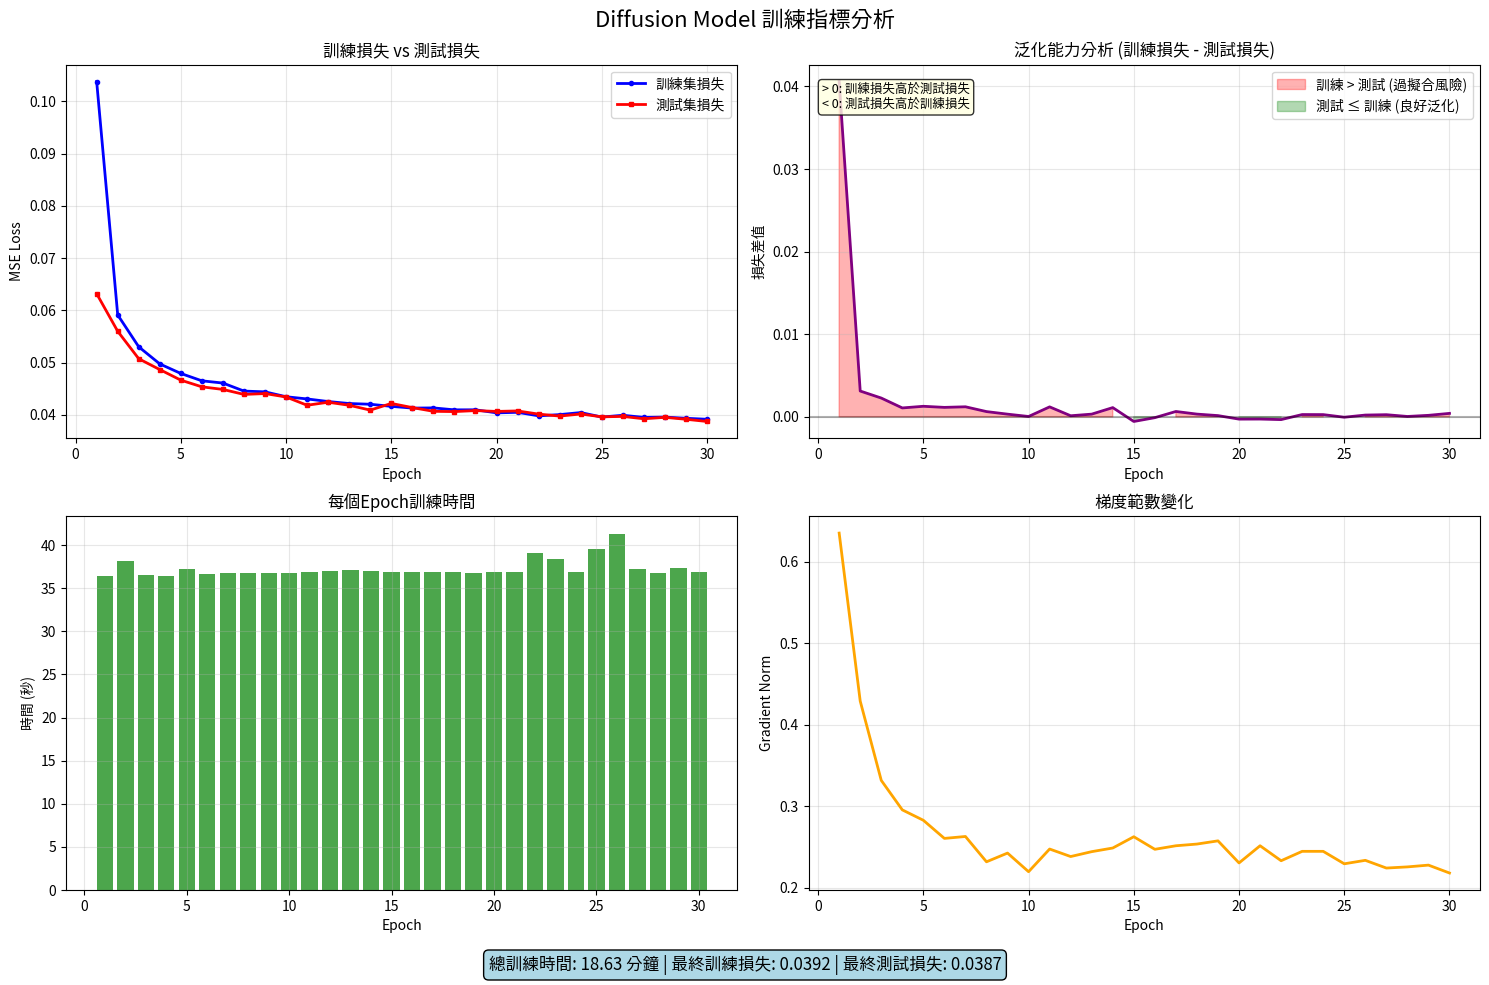

模型已儲存為 'mnist_diffusion_model.pth'


In [ ]:
# 完整的MNIST Diffusion實驗
if __name__ == "__main__":
    # 設定參數
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"使用裝置: {device}")

    batch_size = 128  # 按照圖片要求

    # 1. 載入MNIST資料集
    print("載入MNIST資料集...")
    train_dataloader, test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

    # 2. 建立模型 (MNIST: 1通道, 28x28)
    print("建立Diffusion Model...")
    model = DiffusionModel(img_channels=1, img_size=28, timesteps=1000)
    print(f"模型參數量: {sum(p.numel() for p in model.parameters()):,}")

    # 3. 訓練模型
    print("開始訓練...")
    diffusion_model, training_metrics = train_diffusion_model(
        model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device=device
    )

    plot_training_metrics(training_metrics)



    #儲存模型
    torch.save(diffusion_model.state_dict(), 'mnist_diffusion_model.pth')
    print("模型已儲存為 'mnist_diffusion_model.pth'")


生成影像...
正在生成 10 張MNIST影像...
生成完成！推理時間: 4.52 秒
平均每張圖片: 0.45 秒


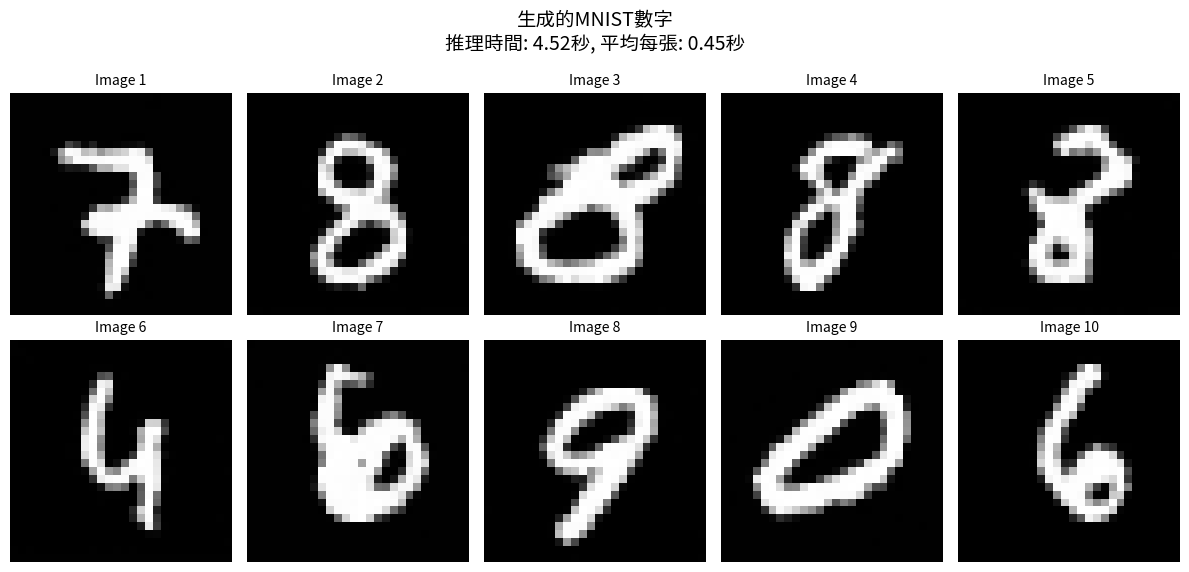

成功生成 10 張MNIST影像
影像尺寸: torch.Size([10, 1, 28, 28])


In [ ]:
print("生成影像...")
# 🎨 生成图像（带推理时间监控）
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# 🖼️ 可视化（显示推理时间）
visualize_mnist_images(diffusion_model_generated_images, "生成的MNIST數字", inference_time)

print(f"成功生成 {diffusion_model_generated_images.shape[0]} 張MNIST影像")
print(f"影像尺寸: {diffusion_model_generated_images.shape}")

# 四種模型生成結果

生成VAE圖片...
正在生成 10 張MNIST圖像...
VAE生成完成！推理時間: 0.0010 秒
平均每張圖片: 0.0001 秒


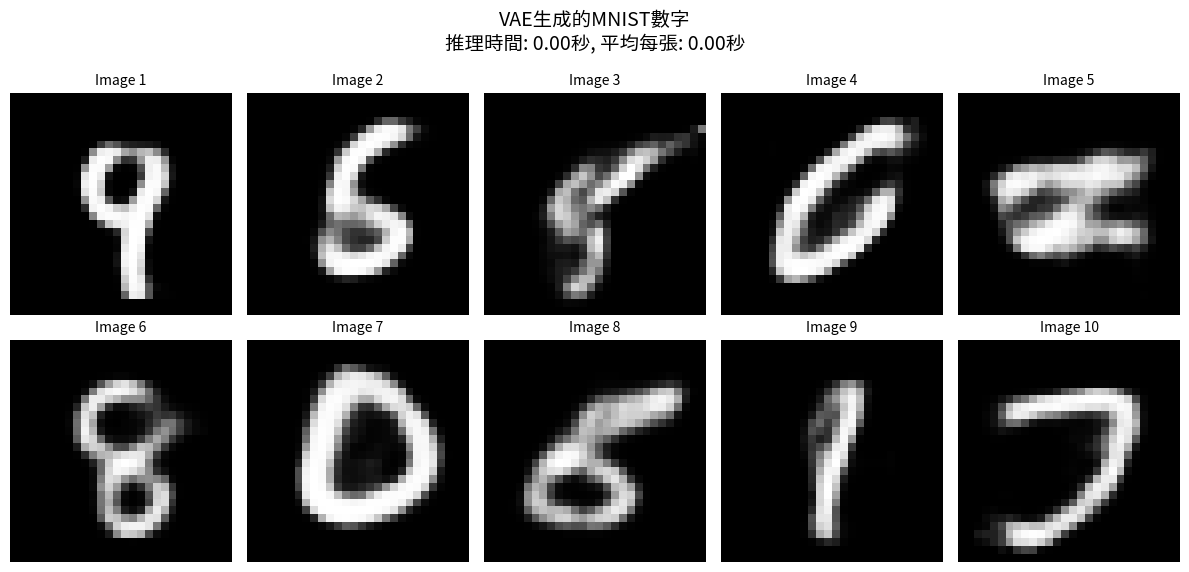

Diffusion model生成影像...
正在生成 10 張MNIST影像...
生成完成！推理時間: 4.23 秒
平均每張圖片: 0.42 秒


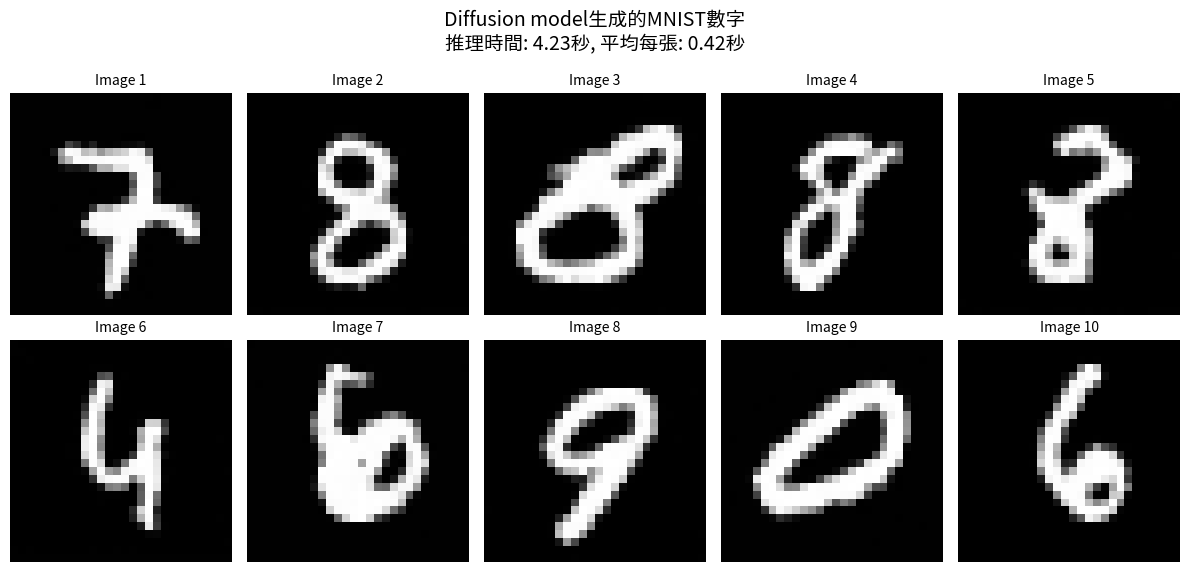

成功生成 10 張MNIST影像
影像尺寸: torch.Size([10, 1, 28, 28])


In [ ]:
#1.VAE
print("生成VAE圖片...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)
visualize_mnist_images(vae_generated_images, "VAE生成的MNIST數字", vae_inference_time)
#4.Diffusion model
print("Diffusion model生成影像...")
# 🎨 生成图像（带推理时间监控）
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# 🖼️ 可视化（显示推理时间）
visualize_mnist_images(diffusion_model_generated_images, "Diffusion model生成的MNIST數字", inference_time)

print(f"成功生成 {diffusion_model_generated_images.shape[0]} 張MNIST影像")
print(f"影像尺寸: {diffusion_model_generated_images.shape}")

In [ ]:
#2.GAN
#3.CGAN

# 清晰度比較

# 可控性（是否能指定數字）

# 訓練/推理效率


# 穩定性（是否出現模糊或 mode collapse）